In [20]:
import os, csv, glob, json
import scipy, matplotlib
import pylab as plt
import numpy as np
from matplotlib import gridspec
from collections import defaultdict
from scipy.io import loadmat
%matplotlib inline

import regnmf.ImageAnalysisComponents as ia

In [3]:
fig_dim = (7.48,9.4)
global_fs= 8 

In [4]:
stim_cut =  (8,12) #(3,5) 

savefile = 'Fig_sPH_new.pdf'
#basepath = os.path.join(os.path.pardir, 'glomcentric_data_preprocessed')
basepath = os.path.realpath(os.path.join(os.path.pardir, 'glomcentric_data'))
datadict_path = os.path.join(basepath, 'DataDicts')

cas2name = {l[0]:l[1] for l in csv.reader(open(os.path.join(datadict_path,'Name2MomCas.tab')),  delimiter='\t')}
cas2name['7440-37-1'] = 'Argon (Control)'

## Helper functions

In [24]:
def no_ticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])
  
# timecourses plotter
rep_param = defaultdict(lambda: {'linewidth':1, 'ls':'--', 'color':'0.8'})
rep_param.update({0:{'linewidth':0.6, 'ls':'--' , 'color':'k','marker':'.', 'ms':2, 'dashes':(2,2)}, 
           1:{'linewidth':0.6, 'ls':'--', 'color':'0.4', 'marker':'.','ms':2, 'dashes':(2,2), 'mec':'0.4'}})
def timeplot(ax, data, mode):
    xtime = np.arange(12)
    stimpos_dict = defaultdict(list)
    for lab_ind, lab in enumerate(data.label_stimuli):
        stimpos_dict[lab].append(lab_ind)
    for stim_num, stim in enumerate(stimpos_dict.keys()):
        for stimrep, stimpos in enumerate(stimpos_dict[stim]):
            xpoints = xtime + stim_num*12
            # only 2 repitions
            if stimrep >1:
                break          
            
            if stim_num == 0: # plot with legend
                ax.plot(xpoints, data.trial_shaped()[stimpos,:,mode], label='trial %d'%(stimrep+1), **rep_param[stimrep])
            else:
                ax.plot(xpoints, data.trial_shaped()[stimpos,:,mode],**rep_param[stimrep])

    myxticks = np.hstack([xtime+i*12 for i in range(len(stimpos_dict))])
    yticks = [0,1,2]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    ax.yaxis.set_tick_params(labelsize=7)
    ax.set_xticks(range(0, len(stimpos_dict)*12, 12))
    ax.set_xticks(myxticks, minor=True)
    ax.set_xticklabels([])
    ax.set_xlim((0,len(stimpos_dict)*12))
    ax.yaxis.set_ticks_position('right')

def base_overlay(ax, bg, toplot, alpha_thres=0.3):
    toplot_rgba = plt.cm.jet(toplot) #cmap_bases((toplot+1)/2.)
    alpha =0.8*np.ones(toplot.shape)
    alpha[np.abs(toplot)<alpha_thres]=0
    toplot_rgba[:,:,3]=alpha
    ax.imshow(bg, interpolation='nearest', cmap=plt.cm.bone, vmin=-.1)
    ax.imshow(toplot_rgba, interpolation='nearest')
    ax.set_axis_off()
    no_ticks(ax)
    """ TODO: STill need to fix the scale of the overlay!
    raise(Exception("fix the temp figure paths - look at the Fig1 notebooks."))
    fig_temp = plt.figure()
    ax_temp = fig_temp.add_subplot(111)
    toplot_rgba = plt.cm.jet(toplot) #cmap_bases((toplot+1)/2.)
    alpha =0.8*np.ones(toplot.shape)
    alpha[np.abs(toplot)<alpha_thres]=0
    toplot_rgba[:,:,3]=alpha
    ax_temp.imshow(bg, interpolation='none', cmap=plt.cm.bone, 
                   extent=[-0.5,toplot.shape[0]-0.5,toplot.shape[1]-0.5,-0.5], vmin=-0.1)
    ax_temp.hold(True)
    ax_temp.imshow(toplot_rgba, interpolation='none')
    ax_temp.set_axis_off()
    no_ticks(ax_temp)
    fig_temp.savefig('/home/jan/mytemp.png', bbox_inches='tight', pad_inches=0)
    plt.close(fig_temp)
    im = plt.imread('/home/jan/mytemp.png')
    ax.imshow(im, interpolation='nearest', extent=[-0.5,toplot.shape[0]-0.5,toplot.shape[1]-0.5,-0.5])
    no_ticks(ax)"""
    
def condense_list_dict(dic, reducefct=np.mean):
    ''' apply reducefct to every value of dictionary'''
    reduced_dict = {}
    for k, v in dic.items():
        reduced_dict[k] = reducefct(v)
    return reduced_dict

### Get the data

In [9]:
animal = '120309FRV'
method =  'nnmf_20_sm5_convex_negTimelowSP_sp*_sph_meas'
#method =  'nnmf_20_sm5_convex_negTimelowSP_sp01_sph_meas'

#filt_data_file = os.path.join(basepath, 'MOBconverted', animal, 'sph_meas') #?
#bg_file = os.path.join(basepath, 'MOBconverted', animal, 'bg.png') #?
#green_file = os.path.join(basepath, 'MOBconverted', animal, 'green.png') # green image
#mf_filename = glob.glob(os.path.join(basepath, 'MOBdecomposed', animal, method+'.npy'))

filt_data_file = os.path.join(basepath, 'MOBconverted', animal, 'sph_meas') #?
bg_file = os.path.join(basepath, 'MOBconverted', animal, 'bg.png') #?
green_file = os.path.join(basepath,  'MOBconverted', animal, 'green.png') # green image
mf_filename = os.path.join(basepath, 'MOBdecomposed', animal, method+'.npy')
mf_filename_globbed = glob.glob(mf_filename)
assert len(mf_filename_globbed)==1, "mf_filename was '{}', glob result {}".format(
                                                    mf_filename, mf_filename_globbed)
mf_filename = mf_filename_globbed[0].split('.')[0]

frv_file = os.path.join(basepath, 'MOBraw', animal, '2p', 'zstack1.mat')
frv_filepre = os.path.join(basepath, 'MOBraw', animal, '2p', 'zstack0.mat')

#### Load example data

In [11]:
filt_data_raw = ia.TimeSeries()
filt_data_raw.load(filt_data_file)
filt_data = ia.TrialMean()(ia.CutOut(stim_cut)(filt_data_raw))
odor_mask = np.array(['o' in lab for lab in filt_data.label_stimuli])
filt_data = ia.SelectTrials()(filt_data, odor_mask)
filt_data.label_stimuli = [i.split('_')[0] for i in filt_data.label_stimuli]
filt_data = ia.SingleSampleResponse()(filt_data)

mf = ia.TimeSeries()
mf.load(mf_filename)
odor_mask = np.array(['o' in lab for lab in mf.label_stimuli])
mf = ia.SelectTrials()(mf, odor_mask)
mf.label_stimuli = [i.split('_')[0] for i in mf.label_stimuli]

bg = plt.imread(bg_file)
frv = loadmat(frv_file)
frvpre = loadmat(frv_filepre)

rois = ia.TimeSeries()
#rois.load(os.path.join(basepath, 'MOBconverted', animal, 'rois'))
rois.load(os.path.join(basepath, 'MOBconverted', animal, 'rois'))

#### Load sph spectrum

In [15]:
average_function = np.median
#method =  'nnmf_20_sm5_convex_negTimelowSP_sp*_sph_measnormed'
method =  'nnmf_50_sm2_convex_negTimelowSP_sp*_sph_measnormed'
mor182spec_file = os.path.join(basepath, 'DataDicts', 'MOR18-2spec_sph.json')
#mor182spec_file = os.path.join(basepath, 'DataDicts', 'MOR18-2spec.json')
mor182spec = json.load(open(mor182spec_file))

#Select only pure odors
pure_odors = [o for o in mor182spec[method].keys() if (len(o.split('_'))<2)]
pure_odor_resp = [average_function(mor182spec[method][o]) for o in pure_odors]
odors_sorted = [pure_odors[i] for i in np.argsort(pure_odor_resp)]
spec = [average_function(mor182spec[method][i]) for i in odors_sorted]

In [16]:
mor182spec.keys()

[u'nnmf_50_sm2_convex_negTimelowSP_sp*_sph_meas',
 u'nnmf_20_sm5_convex_negTimelowSP_sp*_sph_measnormed',
 u'nnmf_50_sm2_convex_negTimelowSP_sp*_sph_measnormed']

#### Load ios spectrum

In [17]:
methodIOS =  'nnmf_200_sm2_convex_negTimelowSP_sp*_ios_measnormed'
mor182specIOS_file = os.path.join(basepath, 'DataDicts', 'MOR18-2spec.json')
mor182specIOS = json.load(open(mor182specIOS_file))

#Get response for odors included in SPH measurements
IOSspec = [average_function(mor182specIOS[methodIOS][o]) for o in odors_sorted]

#mask to exclude odors with less than 3 IOS measurements
num_IOS = [len(mor182specIOS[methodIOS][o]) for o in odors_sorted]
mask = np.array(num_IOS)>3

## Plot the data

In [21]:

layout = {   'axes.labelsize': 8,
             'axes.linewidth': .5, 
             'xtick.major.size': 2,     # major tick size in points
             'xtick.minor.size': 1,     # minor tick size in points
             'xtick.labelsize': 7,       # fontsize of the tick labels
             'xtick.major.pad': 2,  
             
             'ytick.major.size': 2,      # major tick size in points
             'ytick.minor.size': 1,     # minor tick size in points
             'ytick.labelsize':7,       # fontsize of the tick labels
             'ytick.major.pad': 2,
             'mathtext.default' : 'regular'
             }

import matplotlib as mpl
for k, v in layout.items():
    mpl.rcParams[k] = v 

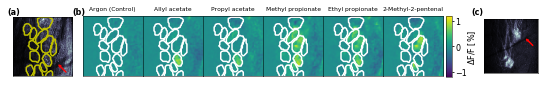

In [28]:
fig  = plt.figure(figsize=fig_dim) # comment out to have it all in one fig
global_fs= 8 


cas2plot =['7440-37-1', '591-87-7', '109-60-4', '554-12-1',  '105-37-3', '623-36-9']

bottom_line1 = 0.88
# plot resting fluo0 
gs = gridspec.GridSpec(1,1)
gs.update(**{'left':0.015, 'right':0.125, 'top':0.97, 'bottom':bottom_line1})
fig.text(0.005, 0.97, '(a)', fontweight='bold', fontsize=global_fs, ha='left', va='bottom')

ax = fig.add_subplot(gs[0])
im_h = ax.imshow(np.mean(frvpre['ch2'][:,:,10:], axis=2), interpolation='none', cmap=plt.cm.bone)
imsize = frvpre['ch2'].shape[:2]
for roi in rois.shaped2D():
    ax.contour(roi, [0.5], colors=['y'], extent=[0,imsize[0],0,imsize[1]])
no_ticks(ax)
ax.arrow(398+65,415+65, -50, -50, head_width=20, head_length=20, fc='r', ec='r')


# plot image maps
gs = gridspec.GridSpec(1,6)
gs.update(**{'left':0.145, 'right':0.815, 'top':0.97, 'bottom':bottom_line1, 'wspace':0.})
fig.text(0.15, 0.97, '(b)', fontweight='bold', fontsize=global_fs, ha='right', va='bottom')


for ix, cas in enumerate(cas2plot):
    toplot = filt_data.shaped2D()[filt_data.label_stimuli.index(cas)]
    ax = fig.add_subplot(gs[0,ix])
    im_h = ax.imshow(toplot, interpolation='none', vmin=-1.2, vmax=1.2)
    ax.set_title(cas2name[cas], size=6)
    # draw rois
    for roi in rois.shaped2D():
        ax.contour(roi, [0.5], colors=['w'])
    no_ticks(ax)
    
# add colorbar
axbar = fig.add_axes([0.82, bottom_line1, 0.01, 0.97-bottom_line1])
cbar = fig.colorbar(im_h, axbar)
cbar.set_ticks([-1,0,1])
cbar.set_label(r'$\Delta F/F$'+ u' [%]', size=global_fs, labelpad=-1)
axbar.yaxis.set_tick_params(labelsize=global_fs, pad=2)
      
# plot resting fluo post mortem
gs = gridspec.GridSpec(1,1)
gs.update(**{'left':0.89, 'right':0.99, 'top':0.97, 'wspace':0., 'bottom':bottom_line1})
'''
ax = fig.add_subplot(gs[0])
im_h = ax.imshow(np.mean(frv['ch2'], axis=2), interpolation='none', cmap=plt.cm.bone)
no_ticks(ax)
'''
ax = fig.add_subplot(gs[0])
fig.text(0.89, 0.97, '(c)', fontweight='bold', fontsize=global_fs, ha='right', va='bottom')
im_h = ax.imshow(np.mean(frv['ch1'], axis=2), interpolation='none', cmap=plt.cm.bone)
ax.arrow(402+65,185+65, -50, -50, head_width=20, head_length=20, fc='r', ec='r')
no_ticks(ax)

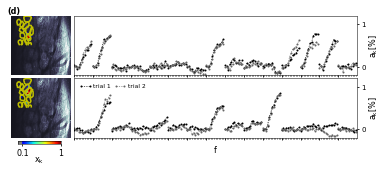

In [30]:
fig  = plt.figure(figsize=fig_dim)

components2plot = [1,2]

gs = gridspec.GridSpec(2,2, width_ratios=[1.1,5])
gs.update(**{'left':0.015, 'right':0.66, 'top':0.85, 'bottom':0.67, 'wspace':0.01, 'hspace':0.05})

fig.text(0.01, 0.85, '(d)', fontweight='bold', fontsize=global_fs, ha='left', va='bottom')


for ix, comp in enumerate(components2plot):
    ax = fig.add_subplot(gs[ix,0])
    base_overlay(ax, bg, mf.base.shaped2D()[comp], alpha_thres=0.1)
    for roi in rois.shaped2D():
        ax.contour(roi, [0.5], colors=['y'])
    ax = fig.add_subplot(gs[ix,1])
    timeplot(ax, mf, comp)
    ax.set_ylabel('$a_k$' + u'[%]', size=global_fs, labelpad=2)
    ax.set_ylim([-0.2,1.2])
    ax.yaxis.set_tick_params(pad=2)
    ax.yaxis.set_label_position('right')
ax.set_xlabel('f', size=global_fs)

# make legend
ax.legend(loc = 'upper left', numpoints=2, ncol=2, prop={'size':6}, columnspacing=0.5, 
          handlelength=2, handletextpad=0.3, frameon=False, borderaxespad=0.5)

# colormap
jetcmap = plt.cm.get_cmap("jet", 20) #generate a jet map with 20 values
jet_vals = jetcmap(np.arange(20)) #extract those values as an array
jet_vals[0] = [0.5, 0.5, 0.5, 1] #change the first value
jet_vals[1] = [0.5, 0.5, 0.5, 1] #change the first value
newcmap = mpl.colors.LinearSegmentedColormap.from_list("newjet", jet_vals)
    
# colorbar
axbar = fig.add_axes([0.03,0.66,0.08,0.005])
colordata = np.linspace(0,1,101)
colordata[0:10]=0
axbar.imshow(colordata[:,np.newaxis].T, cmap=newcmap, aspect='auto')
axbar.set_yticks([])
axbar.xaxis.set_tick_params(labelsize=global_fs, pad=2)
axbar.set_xticks([10, 101])
axbar.set_xticklabels([0.1,1])
axbar.set_xlabel('$x_{k}$', size=global_fs, labelpad=-2)

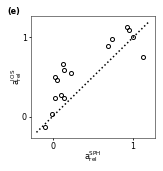

In [31]:
fig  = plt.figure(figsize=fig_dim) # comment out to have it all in one fig

gs = matplotlib.gridspec.GridSpec(1,1, top=0.85, bottom=0.67, left=0.75, right=0.98)
fig.text(0.73, 0.85, '(e)', fontweight='bold', fontsize=global_fs, ha='right', va='bottom')

ax = fig.add_subplot(gs[0])
ax.plot(np.array(spec)[mask], np.array(IOSspec)[mask], 'o', mfc='none', mec='k', ms=4, mew=1)
ax.plot([-0.2,1.2],[-0.2,1.2],':k')
#ax.plot(iso_r.X_, iso_r.y_)
ax.xaxis.set_tick_params(labelsize=global_fs)
ax.set_xticks([0,1])
#ax.set_yticks(np.array(IOSspec)[mask], minor=True)
#ax.set_yticklabels([cas2name[odors_sorted[i]].decode("utf8") for i in np.where(mask)[0]], size=6, minor=True)
ax.yaxis.set_tick_params(labelsize=global_fs)#label2On=True, label1On=False)
ax.set_yticks([0,1])
ax.set_ylabel('$a_{rel}^{IOS}$', size=global_fs, labelpad=-2)
ax.set_xlabel('$a_{rel}^{SPH}$', size=global_fs, labelpad=-2)

#fig.savefig(savefile, bbox_inches='tight')
plt.show()